# **SET-UP**

In this section, the relavant libraries are imported, and the training, validation and test datasets are prepared.

If the notebook is running on Google Colab, the data can be downloaded to the environment by running the corresponding cell.

In [ ]:
# imports

import os
import sys
from pathlib import Path

import torch
import torch.nn as nn
import torch.nn.functional
from torchvision import transforms

import matplotlib.pyplot as plt
import numpy as np

import cv2
from PIL import Image

### Download Data into Google Colab Environment

This cell should only be executed if the notebook is running on Google Colab.

If the notebook is running locally with the data already situated in the correct directory, this cell block should **not** be run.

In [ ]:
# download if zip files not already downloaded
if not os.path.exists('data.zip'):
    !gdown '1KCEr8wD4vGuYhop8ShshLFPnx-3wzeSW'
else:
    print('data.zip already exists')

# unzip if folders don't already exist
if not os.path.exists('data'):
    !unzip -qq data.zip
    !rm data.zip
else:
    print('data folder already exists')

Downloading...
From (original): https://drive.google.com/uc?id=1KCEr8wD4vGuYhop8ShshLFPnx-3wzeSW
From (redirected): https://drive.google.com/uc?id=1KCEr8wD4vGuYhop8ShshLFPnx-3wzeSW&confirm=t&uuid=9d02359d-42b2-4d52-83e8-c5378222802c
To: /content/data.zip
100% 289M/289M [00:04<00:00, 65.2MB/s]


In [ ]:
# download if zip files not already downloaded
if not os.path.exists('utils.zip'):
    !gdown '1gpmibySGF2wxCMRcE_0V9duUf27U5270'
else:
    print('utils.zip already exists')

# unzip if folders don't already exist
if not os.path.exists('utils'):
    !unzip -qq utils.zip
    !rm utils.zip
else:
    print('utils folder already exists')

Downloading...
From: https://drive.google.com/uc?id=1gpmibySGF2wxCMRcE_0V9duUf27U5270
To: /content/utils.zip
100% 2.85k/2.85k [00:00<00:00, 13.5MB/s]


In [ ]:
# download if zip files not already downloaded
if not os.path.exists('depth_estimation.zip'):
    !gdown '1aNww-oYs-eObTImT923rFejQDDLsfOI6'
else:
    print('depth_estimation.zip already exists')

# unzip if folders don't already exist
if not os.path.exists('depth_estimation'):
    !unzip -qq depth_estimation.zip
    !rm depth_estimation.zip
else:
    print('depth_estimation folder already exists')

Downloading...
From (original): https://drive.google.com/uc?id=1aNww-oYs-eObTImT923rFejQDDLsfOI6
From (redirected): https://drive.google.com/uc?id=1aNww-oYs-eObTImT923rFejQDDLsfOI6&confirm=t&uuid=49c2dceb-b45a-4046-962c-5b1845572c06
To: /content/depth_estimation.zip
100% 55.4M/55.4M [00:00<00:00, 61.5MB/s]


In [ ]:
# download if zip files not already downloaded
if not os.path.exists('object_segmentation.zip'):
    !gdown '1MyVDhgv_Ni2WQhRUvVupyejGuZE3Sdkw'
else:
    print('object_segmentation.zip already exists')

# unzip if folders don't already exist
if not os.path.exists('object_segmentation'):
    !unzip -qq object_segmentation.zip
    !rm object_segmentation.zip
else:
    print('object_segmentation folder already exists')

Downloading...
From: https://drive.google.com/uc?id=1MyVDhgv_Ni2WQhRUvVupyejGuZE3Sdkw
To: /content/object_segmentation.zip
100% 2.61k/2.61k [00:00<00:00, 9.44MB/s]


## Constructing Datasets

Informally experimenting with various batch sizes,demonstrated that a batch size of four yielded the best results.

In [ ]:
# batch size
B = 4

The appropriate transformations can be applied for training, validation and test data. The dataset is split into 60% for training data, 10% for validation data, and 30% for test data.

In [ ]:
from torch.utils.data import random_split, DataLoader
from utils.seq_dataset import SeqDataset
from utils.data_management import get_transform, initialize_loader

# set up dataset
dataset = SeqDataset(root_dir='data', transform=None)

# picking out the sizes
train_size = int(0.6 * len(dataset))              # 60% for training
val_size = int(0.1 * len(dataset))                # 10% for validation
test_size = len(dataset) - train_size - val_size  # 30 for testing

# split the dataset into train, validation, and test sets
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# dataloaders
train_loader = initialize_loader(train_dataset, get_transform("train"), B, True)
val_loader = initialize_loader(val_dataset, get_transform("validation"), B, False)
test_loader = initialize_loader(test_dataset, get_transform("test"), B, False)

### Visualize Data

This cell can be optionally executed to visualize the structure of the dataset.

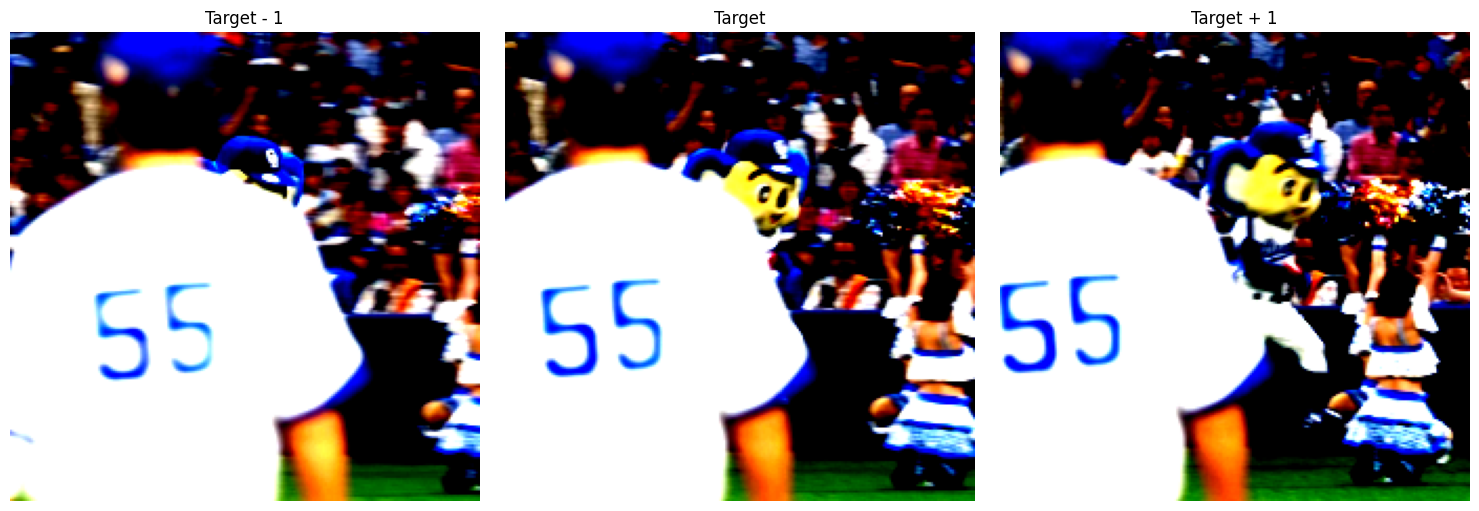

In [ ]:
tgt, [s1, s2] = train_dataset[10]
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.title("Target - 1")
plt.imshow(s1.permute(1, 2, 0).numpy())
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title("Target")
plt.imshow(tgt.permute(1, 2, 0).numpy())
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title("Target + 1")
plt.imshow(s2.permute(1, 2, 0).numpy())
plt.axis('off')

plt.tight_layout()
plt.show()

# **Scene Graph Constructor**

#### Helper Functions

In [ ]:
def extract_features(extractor, image):
    with torch.no_grad():
        image = F.interpolate(image, size=(224, 224), mode='bilinear', align_corners=False)
        image = image * 2 - 1
        output = extractor.forward_features(image)
        patch_tokens = output["x_norm_patchtokens"]
        B, N, C = patch_tokens.shape
        H = W = int(N ** 0.5)
        features = patch_tokens.permute(0, 2, 1).reshape(B, C, H, W)
    return features

def get_masks(obj_net, features):
    with torch.no_grad():
      masks = obj_net(features)
    return masks

def get_depth(depth_net, image):
    with torch.no_grad():
        disp = depth_net(tgt)
        disp = F.interpolate(disp, size=(224, 224), mode='bilinear', align_corners=True)
        depth = 1 / (disp + 1e-6)
    return depth

def get_centroid(mask):
    if mask.dim() == 3:
        mask = mask[0]
    y, x = torch.nonzero(mask, as_tuple=True)
    if len(x) == 0:
        return torch.tensor([0.0, 0.0], device=mask.device)
    centroid = torch.stack([x.float().mean(), y.float().mean()])
    return centroid

#### Loss Functions

In [ ]:
import torch
import torch.nn.functional as F

def contrastive_loss(nodes):
    nodes_batch = torch.stack(nodes, dim=0)

    B, N, D = nodes_batch.shape

    anchors = nodes_batch[:, 0::2, :]
    positives = nodes_batch[:, 1::2, :]

    anchors = F.normalize(anchors, dim=-1)
    positives = F.normalize(positives, dim=-1)
    all_nodes = F.normalize(nodes_batch, dim=-1)

    pos_sim = torch.sum(anchors * positives, dim=-1)

    idxs = torch.arange(N, device=nodes_batch.device)
    idxs = idxs.view(1, N, 1)

    anchor_idxs = torch.arange(0, N, 2, device=nodes_batch.device)
    pos_idxs = anchor_idxs + 1

    anchor_idxs = anchor_idxs.view(1, 1, -1)
    pos_idxs = pos_idxs.view(1, 1, -1)
    mask = (idxs != anchor_idxs) & (idxs != pos_idxs)

    all_nodes_T = all_nodes.transpose(1, 2)
    sim_all = torch.bmm(anchors, all_nodes_T)

    sim_neg = sim_all.masked_fill(~mask.transpose(1, 2), float('-inf'))

    neg_sim = torch.logsumexp(sim_neg, dim=-1)

    loss = -pos_sim + neg_sim

    return loss.mean()


In [ ]:
def mse_debug_loss(nodes_batch):
    total_loss = 0.0
    for nodes in nodes_batch:
        target = torch.zeros_like(nodes)
        total_loss += F.mse_loss(nodes, target)
    return total_loss / len(nodes_batch)


In [ ]:
def mse_loss(nodes_batch):
    nodes = torch.stack(nodes_batch, dim=0)
    target = torch.zeros_like(nodes)
    loss = F.mse_loss(nodes, target)
    return loss

In [ ]:
import torch
import torch.nn.functional as F

def triplet_loss(nodes_batch, margin=1.0):
    total_loss = 0.0
    total_triplets = 0

    for nodes in nodes_batch:
        num_nodes = nodes.shape[0]
        nodes = F.normalize(nodes, dim=1)

        for i in range(0, num_nodes - 1, 2):
            anchor = nodes[i]
            positive = nodes[i+1]

            negatives = torch.stack([nodes[j] for j in range(num_nodes) if j != i and j != i+1])

            pos_dist = F.pairwise_distance(anchor.unsqueeze(0), positive.unsqueeze(0), p=2)
            neg_dists = F.pairwise_distance(anchor.unsqueeze(0), negatives, p=2)

            hardest_neg_dist = neg_dists.min()

            loss_i = F.relu(pos_dist - hardest_neg_dist + margin)
            total_loss += loss_i
            total_triplets += 1

    return total_loss / total_triplets if total_triplets > 0 else torch.tensor(0.0, device=nodes_batch[0].device)

#### Scene Constructor

In [ ]:
class SceneGraphConstructor(nn.Module):
    def __init__(self, feat_dim, node_dim, edge_dim):
        super().__init__()
        self.node_mlp = nn.Sequential(
            nn.Linear(feat_dim + 1, 128), nn.ReLU(),
            nn.Linear(128, node_dim)
        )
        self.edge_mlp = nn.Sequential(
            nn.Linear(2 * node_dim + 3, 128), nn.ReLU(),
            nn.Linear(128, edge_dim)
        )

    def forward(self, masks, depth, feats):
        B, N_obj, H, W = masks.shape
        _, C, Hf, Wf = feats.shape
        device = feats.device

        all_nodes = []
        all_edge_index = []
        all_edge_attr = []

        for b in range(B):
            m = masks[b]
            d = depth[b, 0]
            f = feats[b]


            if (H, W) != (Hf, Wf):
                m = F.interpolate(m.unsqueeze(0), size=(Hf, Wf), mode='bilinear', align_corners=False).squeeze(0)
            if d.shape != (Hf, Wf):
                d_resized = F.interpolate(d.unsqueeze(0).unsqueeze(0), size=(Hf, Wf), mode='bilinear', align_corners=False).squeeze(0).squeeze(0)
            else:
                d_resized = d

            node_feats = []
            for i in range(N_obj):
                mask_i = m[i]
                pooled_feat = (mask_i * f).view(C, -1).sum(dim=1) / (mask_i.sum() + 1e-6)
                avg_depth = (mask_i * d_resized).sum() / (mask_i.sum() + 1e-6)
                node_input = torch.cat([pooled_feat, avg_depth.unsqueeze(0)])
                v_i = self.node_mlp(node_input)
                node_feats.append(v_i)

            node_feats = torch.stack(node_feats)
            all_nodes.append(node_feats)

            edge_idx = []
            edge_feats = []

            for i in range(N_obj):
                for j in range(N_obj):
                    if i == j: continue

                    delta_pos = get_centroid(m[j]) - get_centroid(m[i])
                    delta_depth = node_feats[j][-1] - node_feats[i][-1]

                    edge_input = torch.cat([node_feats[i], node_feats[j], delta_pos, delta_depth.unsqueeze(0)])
                    e_ij = self.edge_mlp(edge_input)

                    edge_idx.append([i, j])
                    edge_feats.append(e_ij)

            edge_index = torch.tensor(edge_idx, device=device).T
            edge_attr = torch.stack(edge_feats)

            all_edge_index.append(edge_index)
            all_edge_attr.append(edge_attr)

        return all_nodes, all_edge_index, all_edge_attr

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from utils.trainer import Trainer

class ConstructionTrainer(Trainer):
    def __init__(self, constructor, optimizer, train_loader, device, obj_net, depth_net, dino, epochs=100):

        # initialize parameters in general trainer class
        super().__init__(
            model=constructor,
            optimizer=optimizer,
            train_loader=train_loader,
            device=device,
            epochs=epochs)

        self.dino = dino
        self.depth_net = depth_net
        self.obj_net = obj_net

        self.model.to(device)
        self.dino.eval()
        self.depth_net.eval()
        self.obj_net.eval()

    def fwd_pass(self, input_data):

        # unpack input data
        tgt, _ = input_data
        tgt = tgt.to(self.device)

        # components of feature vector
        features = extract_features(self.dino, tgt)
        masks = get_masks(self.obj_net, features)
        depth_map = get_depth(self.depth_net, tgt)

        # values of the graph
        nodes, edge_index, edge_attr = self.model(masks, depth_map, features)

        # compute loss
        #loss = contrastive_loss(nodes)
        loss = mse_loss(nodes)

        return loss

#### Training

In [ ]:
from utils.visual_helpers import plot_train_loss

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

##### Load Pretrained Models

In [ ]:
# load pretrained dino for backbone feature detector
dino = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitb14').to(device)
feat_dim = 768  # fixed value

Using cache found in /root/.cache/torch/hub/facebookresearch_dinov2_main


In [ ]:
from depth_estimation.depth_net import DepthNet
from depth_estimation.pose_net import PoseNet

depth_net = DepthNet().to(device)
pose_net = PoseNet().to(device)

depth_net.load_state_dict(torch.load("depth_estimation/weights/depth_D_weights.pth", map_location=torch.device('cpu')))
pose_net.load_state_dict(torch.load("depth_estimation/weights/pose_D_weights.pth", map_location=torch.device('cpu')))

<All keys matched successfully>

In [ ]:
from object_segmentation.object_detector import ObjSegmentation

obj_net = ObjSegmentation(feat_dim).to(device)

obj_net.load_state_dict(torch.load("object_segmentation/weights/solo_obj_detector_a.pth", map_location=torch.device('cpu')))

<All keys matched successfully>

In [ ]:
node_dim = 64
edge_dim = 64
sg_constructor = SceneGraphConstructor(feat_dim, node_dim, edge_dim).to(device)
optimizer = torch.optim.Adam(sg_constructor_b.parameters(), lr=1e-3)
sg_trainer = ConstructionTrainer(sg_constructor_b, optimizer, train_loader, device, obj_net, depth_net, dino, epochs=5)

In [ ]:
sg_trainer_b.train()


EPOCH 1 -----------------------------
[average loss: 0.0011]

EPOCH 2 -----------------------------
[average loss: 0.0000]

EPOCH 3 -----------------------------
[average loss: 0.0000]

EPOCH 4 -----------------------------


KeyboardInterrupt: 

# **GNN ARCHITECTURE**

In [ ]:
class SpatioTemporalGNNLayer(nn.Module):
    def __init__(self, in_dim: int, out_dim: int, use_attention: bool = False):
        super().__init__()
        if use_attention and GATConv is not None:
            self.spatial_conv = GATConv(in_dim, out_dim // 1)
        else:
            self.spatial_conv = SAGEConv(in_dim, out_dim)

        # temporal transform for cross-frame messages
        self.temporal_mlp = nn.Sequential(
            nn.Linear(in_dim, out_dim),
            nn.ReLU(),
            nn.Linear(out_dim, out_dim)
        )

        self.update_mlp = nn.Sequential(
            nn.Linear(out_dim * 2, out_dim),
            nn.ReLU(),
            nn.Linear(out_dim, out_dim)
        )

    def forward(self, x: torch.Tensor, edge_index: torch.Tensor, temporal_messages: Optional[Tuple[torch.Tensor, torch.Tensor]] = None) -> torch.Tensor:
        # spatial
        x_spatial = self.spatial_conv(x, edge_index)

        # temporal
        if temporal_messages is not None:
            idx_recv, raw_msgs = temporal_messages
            # transform raw messages
            transformed = self.temporal_mlp(raw_msgs)
            # create zero tensor and scatter
            temp = torch.zeros((x.shape[0], transformed.shape[1]), device=x.device)
            temp[idx_recv] = transformed
        else:
            temp = torch.zeros((x.shape[0], x_spatial.shape[1]), device=x.device)

        concat = torch.cat([x_spatial, temp], dim=1)
        out = self.update_mlp(concat)
        return out

In [ ]:
class DynamicGNNTracker(nn.Module):
    def __init__(self, node_in_dim, hidden_dim=256, num_layers=3, cross_k=5):
        super().__init__()
        self.node_in_dim = node_in_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.cross_k = cross_k

        self.input_proj = nn.Linear(node_in_dim, hidden_dim)
        self.layers = nn.ModuleList([SpatioTemporalGNNLayer(hidden_dim, hidden_dim) for _ in range(num_layers)])

        # final projector to identity embedding
        self.id_proj = nn.Sequential(nn.Linear(hidden_dim, hidden_dim), nn.ReLU(), nn.Linear(hidden_dim, hidden_dim))

    def build_cross_frame_edges(self, centroids_t, feats_t, centroids_tp1, feats_tp1):
        if centroids_t.shape[0] == 0 or centroids_tp1.shape[0] == 0:
            return torch.zeros((0,), dtype=torch.long, device=centroids_t.device),
            torch.zeros((0,), dtype=torch.long, device=centroids_t.device),
            torch.zeros((0, feats_t.shape[1]), device=centroids_t.device)

        # distances
        dists = torch.cdist(centroids_t, centroids_tp1)
        k = min(self.cross_k, centroids_tp1.shape[0])
        knn_dst = torch.topk(-dists, k=k, dim=-1).indices

        # flatten to edges
        src_idx = torch.repeat_interleave(torch.arange(centroids_t.shape[0], device=centroids_t.device), k)
        dst_idx = knn_dst.reshape(-1)

        # message features
        msgs = feats_t[src_idx]
        return src_idx, dst_idx, msgs

    def forward(self, frames: List[dict]):
        T = len(frames)
        device = frames[0]['node_feats'].device if T > 0 else torch.device('cpu')

        # project inputs
        for f in frames:
            f['h'] = self.input_proj(f['node_feats'])

        # iterative message passing
        for layer in self.layers:
            new_h = []
            # compute cross-frame candidates
            cross_cache = []
            for t in range(T - 1):
                src_idx, dst_idx, msgs = self.build_cross_frame_edges(frames[t]['centroids'], frames[t]['h'], frames[t+1]['centroids'], frames[t+1]['h'])
                # temporal messages received
                cross_cache.append((src_idx, dst_idx, msgs))

            for t in range(T):
                temporal_messages = None
                if t > 0:
                    src_idx_prev, dst_idx_prev, msgs_prev = cross_cache[t-1]
                    temporal_messages = (dst_idx_prev, msgs_prev)

                h_out = layer(frames[t]['h'], frames[t]['edge_index'], temporal_messages)
                new_h.append(h_out)

            # write back
            for t in range(T):
                frames[t]['h'] = new_h[t]

        # final identity projection
        embeddings = []
        for t in range(T):
            embeddings.append(self.id_proj(frames[t]['h']))

        # compute match matrices w/ cosine similarity
        matches = []
        for t in range(T - 1):
            a = embeddings[t]
            b = embeddings[t + 1]
            if a.shape[0] == 0 or b.shape[0] == 0:
                matches.append(torch.zeros((a.shape[0], b.shape[0]), device=device))
                continue
            sim = F.normalize(a, dim=1) @ F.normalize(b, dim=1).t()
            matches.append(sim)

        return embeddings, matches

# **TRAINING**

In [ ]:
def contrastive_track_loss(sim_matrix, pos_pairs, temp=0.07):
    # convert sim to logits
    logits = sim_matrix / temp
    Nt, Nt1 = logits.shape

    if pos_pairs is None:
        row_pos = torch.argmax(logits, dim=1)
        pos_pairs = [(i, int(row_pos[i].item())) for i in range(Nt)]

    labels = torch.tensor([p[1] for p in pos_pairs], device=logits.device, dtype=torch.long)
    loss = F.cross_entropy(logits, labels)
    return loss

In [ ]:
def cycle_consistency_loss(matches):
    loss = 0.0
    count = 0
    for i in range(len(matches) - 1):
        A = matches[i]
        B = matches[i+1]
        comp = F.softmax(A, dim=1) @ F.softmax(B, dim=1)
        loss = loss + comp.mean()
        count += 1
    if count == 0:
        return torch.tensor(0.0, device=matches[0].device if len(matches) else 'cpu')
    return loss / count